Initialize the Envirnoment where 2 players can compete in a game

In [ ]:
!pip install rlcard
import rlcard
import numpy as np
from rlcard.games.limitholdem import Dealer
from rlcard.games.base import Card
from rlcard.utils.utils import print_card
import random
import matplotlib.pyplot as plt
import time
def init_deck():
    # Initialize deck containing of 10 J Q K A for each suit
    suits = ['S', 'H' , "D" , 'C']
    ranks = ['T', 'J', 'Q' , 'K', 'A']

    #list of cards
    deck=  [Card(suit,rank) for suit in suits for rank in ranks]
    return deck

    """
    get the rank of one from a symbol like  "T" or "Q" ton an integer
    """
def get_rank(rank):
    if rank == '':
        return -1
    elif rank == "T":
        return 1
    elif rank == "J":
        return 2
    elif rank == "Q":
        return 3
    elif rank == "K":
        return 4
    elif rank == "A":
        return 5
    return 0
def is_object_none(obj):
    """
    Check if an object is None and return True if it is None else return
    Args:
        obj: The object to check.

    Returns:
        bool: True if the object is None, False otherwise.
    """
    return obj is None






class Dealer:
    """
        Dealer initializes a deck given by init_deck
        shufles the the deck aka randomizes the cards order
        deals a card , gives the last card in deck

        Returns:
        card
    """
    def __init__(self, np_random):
        self.np_random = np_random
        self.deck = init_deck()
        self.shuffle()
        self.pot = 0

    def shuffle(self):
        self.np_random.shuffle(self.deck)

    def deal_card(self):
        """
        Deal one card from the deck

        Returns:
            (Card): The drawn card from the deck
        """

        return self.deck.pop()


"""
States:
    betting,calling,raising
Available actions:
    for betting:
        bet,check
    for raising:
        call,raise,fold
    for calling:
        call,fold


we need to keep track of the state
current state is marked with 1 and others with 0

1st initialization
bettin_state =1
raising_state= 0
calling_state= 0

state= [betting_state,raising_state,calling_state]
"""

class Judger:
    ''' The Judger class which deciedes the winner between 2 players given their cards and the public  too
        Returns a list of the chips won or lost for every player
    '''
    def __init__(self, np_random):
        ''' Initialize a judger class
        '''
        self.np_random = np_random

    @staticmethod
    def judge_game(players, public_cards):
        ''' Judge the winner of the game.

        Args:
            players (list): The list of players who play the game
            public_card (object): The public card that seen by all the players

        Returns:
            (list): Each entry of the list corresponds to one entry of the
        '''
        # Judge who are the winners
        winners = [0] * len(players)
        fold_count = 0
        ranks_list = []



        #save ranks of the 2 players in ranks list
        for player in players:
            ranks_list.append(get_rank(player.hand.rank))


         #keep track of the max rank between the 2 players
        max_rank = max(ranks_list)

        # First check if anyone has folded then the other wins
        if players[0].status== 'folded':
            winners[1]= 1
        if players[1].status== 'folded':
            winners[0]= 1


        # If any of the players matches both public cards wins. Both the 2 players can win and pot is splitted
        if sum(winners) < 1:
            for idx, player in enumerate(players):
                if player.hand.rank == public_cards[0].rank and player.hand.rank == public_cards[1].rank:
                    winners[idx] = 1

        # If one of the players matches one public cards wins. if both  then check the higher rank , again both can win
        if sum(winners) < 1:
            #Both have one pair
            if (players[0].hand.rank == public_cards[0].rank or players[0].hand.rank == public_cards[1].rank) and (players[1].hand.rank == public_cards[0].rank or players[1].hand.rank == public_cards[1].rank):

                #check the rank
                for idx, player in enumerate(players):
                    if get_rank(player.hand.rank) == max_rank:
                        winners[idx] = 1


            #Only one has a pair
            else:
                for idx, player in enumerate(players):
                    if player.hand.rank == public_cards[0].rank or player.hand.rank == public_cards[1].rank:
                        winners[idx] = 1

        # If non of the above conditions, the winner player is the one with the highest card rank
        if sum(winners) < 1:
            max_index = [i for i, j in enumerate(ranks_list) if j == max_rank]
            for idx in max_index:
                winners[idx] = 1

        if sum(winners) < 1:
            print('ERROR on judging')
        # Compute the total chips
        total = 0
        for p in players:
            total += p.in_chips


        # split the winnikngs in case there are 2 winners
        each_win = float(total) / sum(winners)
        payoffs = []

        # Check every player's winning state and give him the credit
        for i, _ in enumerate(players):
            # winner
            if winners[i] == 1:
                #print(f" winner={players[i].ID}")
                #if player is a winner give him wiining_chips- contributed_chips so  he gets the clear profit
                payoffs.append(each_win - players[i].in_chips)
            # losser
            else:
                #print(f" loser={players[i].ID}")
                #if player is a losser give him -his contributed_chips
                payoffs.append(float(-players[i].in_chips))

        return payoffs



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rlcard: filename=rlcard-1.2.0-py3-none-any.whl size=325799 sha256=cc8014d96ed0e8f325567c65035b07d5caf29a1adc5861975e74b9a9e55a3150
  Stored in directory: /root/.cache/pip/wheels/a5/0a/39/26d73b035027276e526bec94b0217ed799109d7890c34a7d9b
Successfully built rlcard


Initialize the players to play against (Random,Threshold)

In [ ]:

"""
States:
    betting,calling,raising
Available actions:
    for betting:
        bet,check
    for raising:
        call,raise,fold
    for calling:
        call,fold


we need to keep track of the state
current state is marked with 1 and others with 0

1st initialization
bettin_state =1
raising_state= 0
calling_state= 0

state= [betting_state,raising_state,calling_state]
"""

class Random_Agent():
    """
    Random agent implitation
    The action of the agent is decided by a random value

    Dont forgret that an agent is a player too.
"""

    def __init__(self,ID):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.ID = ID
        #playe's status
        self.status = 'alive'

        self.type= 'Random'

        #player's hand
        self.hand = None
        # The chips that this player has put in until now
        self.in_chips = 0

        self.all_chips= 0

        # self.player_id = player_id
    """
    Action of the agent given the state he is in
    """
    def step(self,state,public_cards,decision):
        '''
        Decide the action of the agent given the state


        Public cards and decision is unused
        '''



        #betting state bet or check available
        if(state[0]==1):

            #generate th random number to make the call
            random_num= np.random.randint(2)

            #bet phase
            if(random_num==0):
                action= 'Bet'
            else:
                action= 'Check'

        # raising state  raise, call or fold availble
        elif(state[1]==1):
            #generate th random number to make the call
            random_num= np.random.randint(3)

            #raise phase
            if(random_num==0):
                action= 'Raise'

            #call phsase
            elif(random_num==1):
                action= 'Call'

            #Fold phase
            else:
                action= 'Fold'
        # calling state call or fold available
        elif(state[2]==1):
            #generate th random number to make the call
            random_num= np.random.randint(2)


            #call phsase
            if(random_num==0):
                action= 'Call'

            #Fold phase
            else:
                action= 'Fold'

        #state not defined print error
        else:
            print("Error state at random agent not found")
            action= 'Uknown'

        return action




class Threshold_Agent():
    """
    Threshold agent implitation

    The action of the agent is decided by by the rank of his card
    He basically plays aggressively  at first round with high values of 'K' and 'A' betting or raisinig , callin with Q and folding with '10' and 'J'
    For second round he raises or bets with one pair at least and folds  or checks every other time


    Dont forgret that an agent is a player too.
    """

    def __init__(self,ID):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.ID=ID
        #playe's status
        self.status = 'alive'

        self.type= 'Threshold'

        #player's hand
        self.hand = None
        # The chips that this player has put in until now
        self.in_chips = 0

        self.all_chips= 0

        # self.player_id = player_id
    """
    Action of the agent given the state he is in
    """

    def step(self,state,public_cards,decision):
        '''
        Decide the action of the agent given the state and the public_cards and playe's hand
        threshold players bet or raises with K and A calls with Q and folds with 10 and J

        Decision is unused
        '''
        hand=self.hand
         # 1st round without public cards revealed yet
        if(is_object_none(public_cards)):
            #betting state bet or check available
            if( state[0]==1):

                if(hand.rank== 'K' or hand.rank == 'A'):
                    #bet phase

                    action= 'Bet'
                else:
                    action= 'Check'

            # raising state  raise, call or fold availble
            elif(state[1]==1):

                #raise phase
                if(hand.rank== 'K' or hand.rank == 'A'):
                    action= 'Raise'

                #call phsase
                elif(hand.rank== 'Q' ):
                    action= 'Call'

                #Fold phase
                else:
                    action= 'Fold'
            # calling state call or fold available
            elif(state[2]==1):


                #call phsase
                if(hand.rank== 'K' or hand.rank == 'A'):
                    action= 'Call'


                #Fold phase
                else:
                    action= 'Fold'
            else:
                action="Uknown"
                print('Cant find any state')

        else:
            #betting state bet or check available
            if( state[0]==1):

                if(hand.rank== public_cards[0].rank or hand.rank== public_cards[1].rank ):
                    #bet phase

                    action= 'Bet'
                else:
                    action= 'Check'

            # raising state  raise, call or fold availble
            elif( state[1]== 1 ):

                #raise phase
                if(hand.rank== public_cards[0].rank or hand.rank== public_cards[1].rank):
                    action= 'Raise'

                #call phsase
                elif( hand.rank == 'A'):
                    action= 'Call'


                #Fold phase
                else:
                    action= 'Fold'

            # calling state call or fold available
            elif(state[2] == 1):

                #call phase
                if(hand.rank== public_cards[0].rank or hand.rank== public_cards[1].rank):
                    action= 'Call'

                #call phsase
                elif(hand.rank == 'A'):
                    action= 'Call'



                #Fold phase
                else:
                    action= 'Fold'

            else:
                action="Uknown"
                print('Cant find any state')

        return action

class HumanAgent():
    ''' A human agent. It can be used to play against agents.
        At every action you are given the state you are in ,public cards and your card to decide the action
        Non available actions are not acceptable
    '''
    def __init__(self,ID):
       ''' Initilize the random agent

       Args:
           num_actions (int): The size of the ouput action space
       '''
       self.ID=ID
       #playe's status
       self.status = 'alive'
       self.type= 'Human'

       #player's hand
       self.hand = None
       # The chips that this player has put in until now
       self.in_chips = 0

       self.all_chips= 0

       # self.player_id = player_id



    def step(self,state,public_cards,decision):
        ''' Human agent will display the state and make decisions through interfaces
            Public cards and decision is unused
        '''
        hand= self.hand
        #print public cards and you cards too
        # print_card(hand.get_index())
        # print_card(public_cards)

        #check the state
        if state[0]== 1:
            # print the state we are in aka the available actions
            print("Available actions are 'Check' or 'Bet'")
            # save the available actions to check them
            legal_actions=['Check','Bet']
        elif state[1]== 1:
            # print the state we are in aka the available actions
            print("Available actions are 'Call', 'Raise' or 'Fold'")
            # save the available actions to check them
            legal_actions=['Call','Raise','Fold']

        elif state[2]== 1:
            # print the state we are in aka the available actions
            print("Available actions are 'Call' or 'Fold'")
            # save the available actions to check them
            legal_actions=['Call','Fold']

        action = input('>> You choose action (string): ')
        while action not in legal_actions:
            print('Action illegal...Try again')
            action = input('>> You choose action (string): ')
        return action



Initialize Policy Agent which uses Policy Iteration

In [ ]:
# testing agent uses the policy given from policy agent and competes against others
class Testing_agent():
    ''' Testing agent gets to policy given from policy iteration and returns the Correct action
    '''
    def __init__(self,ID):
       ''' Initilize the random agent

       Args:
           num_actions (int): The size of the ouput action space
       '''
       self.ID=ID
       #playe's status
       self.status = 'alive'

       self.type= 'Testing'
       #player's hand
       self.hand = None
       # The chips that this player has put in until now
       self.in_chips = 0

       self.all_chips= 0

       # self.player_id = player_id

    def getAction(self,decision):
        # get the action from the policy

        if decision== 0:

            action= 'Check'

        elif decision== 1:
            action= 'Bet'
        elif decision== 2:

            action= 'Call'

        elif decision== 3:
            action= 'Raise'

        elif decision== 4:
            action= 'Fold'

        else:
            print("ERROR AT GIVING ACTION")
        return action

    def step(self,state,public_cards,decision):
        '''
            Decide the action of the agent given the state and the public_cards and playe's hand
            threshold players bet or raises with K and A calls with Q and folds with 10 and J
            '''
        if self.ID ==1:
        # player is first to decide so the possible states are 10

            hand=self.hand
            # 1st round without public cards revealed yet
            if(is_object_none(public_cards)):

                if( state[0]==1 ):
                    # 1st action betting state bet or check available with 0 raises in
                    policy_decision=decision[0]
                    action= self.getAction(policy_decision)

                elif(state[2]==1 and self.in_chips==0.5):
                    # calling state   call or fold availble wwith 1 raises in
                    policy_decision=decision[1]
                    action= self.getAction(policy_decision)

                elif(state[2]==1 and self.in_chips==1.5):
                    # calling state   call or fold availble wwith 2 raises in
                    policy_decision=decision[2]
                    action = self.getAction(policy_decision)

                else:
                    action="Uknown"
                    print('Cant find any state')

            else:
            # Round 2 cards are shown
                #betting state bet or check available with only 0.5 chips in
                if( state[0]==1 and self.in_chips == 0.5):
                    policy_decision=decision[3]
                    action = self.getAction(policy_decision)

                #betting state bet or check available with only 1.5 chips in
                elif( state[0]==1 and self.in_chips == 1.5):
                    policy_decision=decision[4]
                    action = self.getAction(policy_decision)

                #betting state bet or check available with only 2.5 chips in
                elif( state[0]==1 and self.in_chips == 2.5):
                    policy_decision=decision[5]
                    action = self.getAction(policy_decision)

                # calling state call or fold available
                elif(state[2] == 1):

                    if(self.in_chips == 0.5):
                    # 0.5 chips already  in
                        policy_decision=decision[6]
                        action = self.getAction(policy_decision)

                    elif self.in_chips == 1.5:
                    # 1.5 chips already in
                        policy_decision=decision[7]
                        action = self.getAction(policy_decision)

                    elif self.in_chips == 2.5:
                    # 2.5 chips already in
                        policy_decision=decision[8]
                        action = self.getAction(policy_decision)

                    elif self.in_chips == 3.5:
                    # 3.5 chips already in
                        policy_decision=decision[9]
                        action = self.getAction(policy_decision)

                else:
                    action="Uknown"
                    print('Cant find any state')

        elif self.ID == 2:
        # player is secont to decide so the possible states are 8

            hand=self.hand
            # 1st round without public cards revealed yet
            if(is_object_none(public_cards)):

                if( state[0]==1 ):
                    # betting state bet or check available with 0 raises in
                    policy_decision=decision[0]
                    action= self.getAction(policy_decision)

                elif(state[1]==1 and self.in_chips==0.5):
                    # calling state   call or fold availble wwith 1 raises in
                    policy_decision=decision[1]
                    action= self.getAction(policy_decision)

                else:
                    action="Uknown"
                    print('Cant find any state')

            else:
            # Round 2 cards are shown
                #betting state bet or check available with only 0.5 chips in
                if( state[0]==1 and self.in_chips == 0.5):
                    policy_decision=decision[2]
                    action = self.getAction(policy_decision)

                #betting state bet or check available with only 1.5 chips in
                elif( state[0]==1 and self.in_chips == 1.5):
                    policy_decision=decision[3]
                    action = self.getAction(policy_decision)

                #betting state bet or check available with only 2.5 chips in
                elif( state[0]==1 and self.in_chips == 2.5):
                    policy_decision=decision[4]
                    action = self.getAction(policy_decision)

                # calling state call or fold available
                elif(state[1] == 1):

                    if(self.in_chips == 0.5):
                    # 0.5 chips already  in
                        policy_decision=decision[5]
                        action = self.getAction(policy_decision)

                    elif self.in_chips == 1.5:
                    # 1.5 chips already in
                        policy_decision=decision[6]
                        action = self.getAction(policy_decision)

                    elif self.in_chips == 2.5:
                    # 2.5 chips already in
                        policy_decision=decision[7]
                        action = self.getAction(policy_decision)

                else:
                    action="Uknown"
                    print('Cant find any state')


        return action




def policy_evaluation(pi, P, gamma = 1.0, epsilon = 1e-10):  #inputs: (1) policy to be evaluated, (2) model of the environment (transition probabilities, etc., see previous cell), (3) discount factor (with default = 1), (4) convergence error (default = 10^{-10})
    t = 0   #there's more elegant ways to do this
    prev_V = np.zeros(len(P)) # use as "cost-to-go", i.e. for V(s')
    while True:
        V = np.zeros(len(P)) # current value function to be learnerd
        for s in range(len(P)):  # do for every state
            for prob, next_state, reward, done in P[s][pi(s)]:  # calculate one Bellman step --> i.e., sum over all probabilities of transitions and reward for that state, the action suggested by the (fixed) policy, the reward earned (dictated by the model), and the cost-to-go from the next state (which is also decided by the model)
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < epsilon: #check if the new V estimate is close enough to the previous one;
            break # if yes, finish loop
        prev_V = V.copy() #freeze the new values (to be used as the next V(s'))
        t += 1
        # Vplot[:,t] = prev_V  # accounting for GUI
    return V



def policy_improvement(V, P, gamma=1.0):  # takes a value function (as the cost to go V(s')), a model, and a discount parameter
    Q = np.zeros((len(P), len(P[0])), dtype=np.float64) #create a Q value array
    for s in range(len(P)):        # for every state in the environment/model
        for a in range(len(P[s])):  # and for every action in that state
            for prob, next_state, reward, done in P[s][a]:  #evaluate the action value based on the model and Value function given (which corresponds to the previous policy that we are trying to improve)
                Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
    new_pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]  # this basically creates the new (improved) policy by choosing at each state s the action a that has the highest Q value (based on the Q array we just calculated)
    # lambda is a "fancy" way of creating a function without formally defining it (e.g. simply to return, as here...or to use internally in another function)
    # you can implement this in a much simpler way, by using just a few more lines of code -- if this command is not clear, I suggest to try coding this yourself

    return new_pi


# policy iteration is simple, it will call alternatively policy evaluation then policy improvement, till the policy converges.
def policy_iteration(P, gamma = 0.7, epsilon = 1e-10):
    t = 0
    random_actions = np.random.choice(tuple(P[0].keys()), len(P))     # start with random actions for each state
    pi = lambda s: {s:a for s, a in enumerate(random_actions)}[s]     # and define your initial policy pi_0 based on these action (remember, we are passing policies around as python "functions", hence the need for this second line)
    while True:
        old_pi = {s: pi(s) for s in range(len(P))}  #keep the old policy to compare with new
        # print("Selected ction at each state ")
        # print(old_pi)
        V = policy_evaluation(pi,P,gamma,epsilon)   #evaluate latest policy --> you receive its converged value function
        # print("Value of each state")
        # print(V)
        pi = policy_improvement(V,P,gamma)          #get a better policy using the value function of the previous one just calculated

        t += 1
        # Pplot[:,t]= [pi(s) for s in range(len(P))]  #keep track of the policy evolution
        # Vplot[:,t] = V                              #and the value function evolution (for the GUI)

        if old_pi == {s:pi(s) for s in range(len(P))}: # you have converged to the optimal policy if the "improved" policy is exactly the same as in the previous step
            break


    # print('converged after %d iterations' %t) #keep track of the number of (outer) iterations to converge
    # for  i in old_pi:
    #     if old_pi[i]==0:
    #         print(f"state{i}:Check")
    #     elif old_pi[i]==1:
    #         print(f"state{i}:Bet")
    #     elif old_pi[i]==2:
    #         print(f"state{i}:Call")
    #     elif old_pi[i]==3:
    #         print(f"state{i}:Raise")
    #     elif old_pi[i]==4:
            print(f"state{i}:Fold")

    return old_pi





class Policy_Agent():
    """
    Threshold agent implitation

    The action of the agent is decided by by the rank of his card
    He basically plays aggressively  at first round with high values of 'K' and 'A' betting or raisinig , callin with Q and folding with '10' and 'J'
    For second round he raises or bets with one pair at least and folds  or checks every other time


    Dont forgret that an agent is a player too.
    """

    def __init__(self,ID):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.ID=ID
        #playe's status
        self.status = 'alive'
        #player's hand
        self.hand = None
        # The chips that this player has put in until now
        self.in_chips = 0

        self.all_chips= 0

        # self.player_id = player_id

        """
        """
    def winning_probs_random(self,public_cards):
        """ probability of winning
        """
        # get max public card
        if(is_object_none(public_cards)== False):
            ranks_list=[]
            for i in range(2):
                ranks_list.append(get_rank(public_cards[i].rank))

            # find the highest public hcard
            if get_rank(public_cards[0].rank)== max(ranks_list):
                highest_pair= public_cards[0]
            else:
                highest_pair= public_cards[1]

        # initialize win probability
        win_p=0
        # win probability if i bet, so in fact the porbability of threshold calling a bet
        win_p_betting=0
        # win probability if i call, so in fact the porbability of threshold betting me
        win_p_calling=0
        # Round 1 no public cards shown
        if(is_object_none(public_cards)):
            if self.hand.rank== 'T':
                win_p = 1/5

            elif self.hand.rank== 'J':
                win_p = 2/5

            elif self.hand.rank== 'Q':
                win_p = 3/5

            elif self.hand.rank== 'K':
                win_p = 4/5
                win_p_betting=1
            elif self.hand.rank== 'A':
                win_p = 1
                win_p_betting=1
        # Round 2 public cards available
        else:
            # You have three of a kind you ll win
            if(public_cards[0].rank == public_cards[1].rank and public_cards[0].rank == self.hand.rank):
                win_p= 1
            # Higest pair
            elif((public_cards[0].rank == self.hand.rank or public_cards[1].rank == self.hand.rank) and self.hand.rank == highest_pair.rank):
                # you can win or split which is also aa win
                win_p=1
            # Second highest pair
            elif((public_cards[0].rank == self.hand.rank) or (public_cards[1].rank == self.hand.rank)):

                # lose when opponet has  highest pair with chances of 3/17
                win_p = 14/17
            # NO PAIR FROM NOW ON
            # No pair , same public cards
            elif(public_cards[0].rank == public_cards[1].rank  ):
                if(self.hand.rank == 'A'):
                    # lose when opponet has set
                    win_p= 15/17
                elif(self.hand.rank== 'K' and public_cards[0].rank== 'A'):
                    # lose when opponet has set
                    win_p= 15/17
                elif(self.hand.rank== 'K'):
                    #lose when opponet has A or set
                    win_p= 11/17
                elif(self.hand.rank== 'Q' and get_rank(public_cards[0].rank) > 3):
                    #lose when set of KKs or A and when set of AAs or K
                    win_p= 11/17
                elif(self.hand.rank== 'Q' and get_rank(public_cards[0].rank) < 3):
                    #lose when set of TTs or A or K and when set of 1010s or K or A
                    win_p= 10/17
                elif(self.hand.rank == 'J' and get_rank(public_cards[0].rank) <2):
                    #lose when set of 1010s or Q or K or A
                    win_p= 3/17
                elif(self.hand.rank == 'J' and get_rank(public_cards[0].rank) >2):
                    #lose when set of QQs  or K or A and when KKs or Q or A and when AA or Q or A
                    win_p= 7/17
                elif(self.hand.rank == 'J' and get_rank(public_cards[0].rank) >2):
                    #lose when set of QQs  or K or A and when KKs or Q or A and when AA or Q or A
                    win_p= 7/17
                elif(self.hand.rank == 'T'):
                    # win only when draw
                    win_p= 3/17

            # No pair ,different public cards
            elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'A'):
                # lose when opponet has pair
                win_p= 11/17

            # No pair ,different public cards
            elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'K'):
                if( public_cards[0].rank== 'A'or public_cards[1].rank== 'A'):
                    # lose when opponet has pair
                    win_p= 11/17
                else:
                    # lose when opponet has pair or 'A'
                    win_p= 7/17

            elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'Q'):
                if((public_cards[0].rank== 'A'and public_cards[1].rank== 'K') or (public_cards[0].rank== 'K'and public_cards[1].rank== 'A')):
                    # lose when opponet has pair
                    win_p= 11/17

                elif((public_cards[0].rank== 'T'and public_cards[1].rank== 'J') or (public_cards[0].rank== 'J'and public_cards[1].rank== 'T')):
                    # lose when opponet has pair or 'A' or 'K'
                    win_p= 3/17
                # 10 A, 10 K , J A , J k
                else:
                    # lose when opponet has pair or highest card which may be K or A
                    win_p= 7/17

            elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'J'):
                if(public_cards[0].rank== 'T' or public_cards[1].rank== 'T'):
                    # win only if opponet has j too
                    win_p= 3/17
                else:
                    # win when opponet has J too or T
                    win_p= 7/17

            elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'T'):
                #  win only if opponet has T too


                win_p= 3/17


        if(win_p==0):
            win_p=5/17
            print("Error finding the winning probability")
            hands=[public_cards[0].rank,public_cards[1].rank,self.hand.rank]
            print(f"Error finding the winning probability {hands}")
        else:
            lose_p= 1-win_p



        return win_p

    def winning_probs_threshold_calling_1(self,public_cards):
        """ probabability of winning if agent calls or raises at round 2 as player 1
        """
        # get max public card
        if(is_object_none(public_cards)== False):
            ranks_list=[]
            for i in range(2):
                ranks_list.append(get_rank(public_cards[i].rank))

            # find the highest public hcard
            if get_rank(public_cards[0].rank)== max(ranks_list):
                highest_pair= public_cards[0]
            else:
                highest_pair= public_cards[1]

        # initialize win probability
        win_p=0

        # You have three of a kind you ll win
        if(public_cards[0].rank == public_cards[1].rank and public_cards[0].rank == self.hand.rank):
            win_p= 1
        # Higest pair
        elif((public_cards[0].rank == self.hand.rank or public_cards[1].rank == self.hand.rank) and self.hand.rank == highest_pair.rank):
            # you can win or split which is also aa win
            win_p=1
        # Second highest pair
        elif((public_cards[0].rank == self.hand.rank) or (public_cards[1].rank == self.hand.rank)):

            # lose when opponet has  highest pair with chances of 3/17
            win_p = 14/17
        # NO PAIR FROM NOW ON
        # No pair , same public cards
        else:
            win_p=0



        lose_p= 1-win_p



        return win_p

    def winning_probs_threshold_calling_2(self,public_cards):
        """ probabability of winning if agent calls or raises at round 2 as player 2
        """
        # get max public card
        if(is_object_none(public_cards)== False):
            ranks_list=[]
            for i in range(2):
                ranks_list.append(get_rank(public_cards[i].rank))

            # find the highest public hcard
            if get_rank(public_cards[0].rank)== max(ranks_list):
                highest_pair= public_cards[0]
            else:
                highest_pair= public_cards[1]

        # initialize win probability
        win_p=0

        # You have three of a kind you ll win
        if(public_cards[0].rank == public_cards[1].rank and public_cards[0].rank == self.hand.rank):
            win_p= 1
        # Higest pair
        elif((public_cards[0].rank == self.hand.rank or public_cards[1].rank == self.hand.rank) and self.hand.rank == highest_pair.rank):
            # you can win or split which is also aa win
            win_p=1
        # Second highest pair
        elif((public_cards[0].rank == self.hand.rank) or (public_cards[1].rank == self.hand.rank)):

            # lose when opponet has  highest pair with chances of 3/17
            win_p = 1/2
        # NO PAIR FROM NOW ON
        # No pair , same public cards
        else:
            win_p=0



        lose_p= 1-win_p



        return win_p


    def winning_probs_threshold_betting_nobet(self,public_cards):
        """probability of agent winning if he bets and  a bet was not done in round 1
        """
        # OPPONET HAS NO A OR K
        # get max public card
        if(is_object_none(public_cards)== False):
            ranks_list=[]
            for i in range(2):
                ranks_list.append(get_rank(public_cards[i].rank))

            # find the highest public hcard
            if get_rank(public_cards[0].rank)== max(ranks_list):
                highest_pair= public_cards[0]
            else:
                highest_pair= public_cards[1]

        # initialize win probabilit y
        win_p=0

        # You have three of a kind you ll win
        if(public_cards[0].rank == public_cards[1].rank and public_cards[0].rank == self.hand.rank):
                win_p= 1
        # Higest pair
        elif((public_cards[0].rank == self.hand.rank or public_cards[1].rank == self.hand.rank) and self.hand.rank == highest_pair.rank):
                # you can win or split which is also aa win
                win_p=1
        # Second highest pair
        elif((public_cards[0].rank == self.hand.rank) or (public_cards[1].rank == self.hand.rank)):

                # lose when opponet has  highest pair with chances of 3/17
                win_p = 14/17
        # NO PAIR FROM NOW ON
        # No pair , same public cards
        elif(public_cards[0].rank == public_cards[1].rank  ):
                if(self.hand.rank == 'A'):
                    # lose when opponet has set
                    win_p= 15/17

                elif self.hand.rank == 'K':
                    win_p= 15/17
                elif self.hand.rank == 'Q':
                    win_p= 15/17
                elif self.hand.rank == 'J':
                    win_p= 11/17
                elif self.hand.rank == 'T':
                    win_p= 7/17
        # No pair ,different public cards
        elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'A'):
                # lose when opponet has pair
                win_p= 11/17
        elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'K'):
                # lose when opponet has pair
                win_p= 11/17
        elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'Q'):
                # lose when opponet has pair
                win_p= 11/17
        elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'J'):
                # lose when opponet has pair and q
                win_p= 7/17
        elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'T'):
                # lose when opponet has pair and q and j
                win_p= 3/17







        lose_p= 1-win_p



        return win_p

    def winning_probs_threshold_betting_bet(self,public_cards):
        """ probability of agent winning if he bets and  a bet was done in round 1
        """
        # OPPONET HAS  A OR K
        # get max public card
        if(is_object_none(public_cards)== False):
            ranks_list=[]
            for i in range(2):
                ranks_list.append(get_rank(public_cards[i].rank))

            # find the highest public hcard
            if get_rank(public_cards[0].rank)== max(ranks_list):
                highest_pair= public_cards[0]
            else:
                highest_pair= public_cards[1]

        # initialize win probability
        win_p=0

        # Round 2 public cards available

        # You have three of a kind you ll win
        if(public_cards[0].rank == public_cards[1].rank and public_cards[0].rank == self.hand.rank):
                win_p= 1
        # Higest pair
        elif((public_cards[0].rank == self.hand.rank or public_cards[1].rank == self.hand.rank) and self.hand.rank == highest_pair.rank):
                # you can win or split which is also aa win
                win_p=1
        # Second highest pair
        elif((public_cards[0].rank == self.hand.rank) or (public_cards[1].rank == self.hand.rank)):

                # lose when opponet has  highest pair with chances of 3/17
                win_p = 14/17
        # NO PAIR FROM NOW ON
        # No pair , same public cards
        elif(public_cards[0].rank == public_cards[1].rank  ):
                if(self.hand.rank == 'A'):
                    # lose when opponet has set
                    win_p= 15/17

                elif self.hand.rank == 'K':
                    #  lose when opponet has set or A
                    win_p= 11/17
                else:
                    win_p= 0
        # No pair ,different public cards
        elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'A'):
                # lose when opponet has pair
                win_p= 11/17
        elif (public_cards[0].rank != public_cards[1].rank and self.hand.rank == 'K'):
                # lose when opponet has pair
                win_p= 7/17
        else:
                win_p =0







        lose_p= 1-win_p



        return win_p
    def winning_probs_threshold_preflop_calling_th(self,public_cards):
        """ initialize win probability
        """
        win_p=0
        # Round 1 no public cards shown
        if(is_object_none(public_cards)):

            if self.hand.rank== 'K' :
                win_p = 10

            elif self.hand.rank== 'A' :
                win_p = 10


            else:
                win_p = -1000000000000000
        return win_p

    def winning_probs_threshold_preflop_calling(self,public_cards):
        """ probability of winning if agent calls preflop
        """
        # initialize win probability
        # Round 1 no public cards shown



        if self.hand.rank == 'Q' :
            win_p = -100.0

        elif self.hand.rank == 'J' :
            win_p = -100.0

        elif self.hand.rank == 'T' :
            win_p = -100.0

        elif self.hand.rank == 'A' :
            win_p = 1

        elif self.hand.rank == 'K' :
            win_p= 1/2



        return win_p

    def winning_probs_threshold_preflop_betting(self,public_cards):
        """ probability of winning if agent bets preflop
        """
        # initialize win probability
        win_p=0
        # Round 1 no public cards shown
        if(is_object_none(public_cards)):

            if self.hand.rank== 'K' :
                win_p = 100

            elif self.hand.rank== 'A' :
                win_p = 100

            else :
                win_p = 1


        win_p=1000
        return win_p

    def winning_probs_threshold_checking_all(self,public_cards):
        """ probability of winning if both player check at round 1 and round 2 too
        """
        # OPP HAS NO K OR A AND NO PAIR
        # get max public card
        if(is_object_none(public_cards)== False):
            ranks_list=[]
            for i in range(2):
                ranks_list.append(get_rank(public_cards[i].rank))

            # find the highest public hcard
            if get_rank(public_cards[0].rank)== max(ranks_list):
                highest_pair= public_cards[0]
            else:
                highest_pair= public_cards[1]

        # initialize win probability
        win_p=0
        # Round 1 no public cards shown
        if(is_object_none(public_cards)):
            if self.hand.rank== 'T':
                win_p = 1/5

            elif self.hand.rank== 'J':
                win_p = 2/5

            elif self.hand.rank== 'Q':
                win_p = 3/5

            elif self.hand.rank== 'K':
                win_p = 4/5

            elif self.hand.rank== 'A':
                win_p = 1
        # Round 2 public cards available
        else:
            # You have three of a kind you ll win
            if(public_cards[0].rank == public_cards[1].rank and public_cards[0].rank == self.hand.rank):
                win_p= 1
            # Higest pair
            elif((public_cards[0].rank == self.hand.rank or public_cards[1].rank == self.hand.rank) and self.hand.rank == highest_pair.rank):
                # you can win or split which is also aa win
                win_p=1
            # Second highest pair
            elif((public_cards[0].rank == self.hand.rank) or (public_cards[1].rank == self.hand.rank)):

                # you win
                win_p = 1
            # NO PAIR FROM NOW ON
            # No pair
            if(self.hand.rank == 'A' or self.hand.rank == 'K'):
                win_p= 1
            elif(self.hand.rank== 'Q' ):
                win_p=1
            elif(self.hand.rank== 'J' ):
                win_p=2/3
            elif(self.hand.rank== 'T'):
                win_p=1/3
            else:
                win_p=0
                print("error at finding checking prob")
                print(f"public cards {public_cards[0].rank},{public_cards[0].rank} self hand{self.hand.rank}")

        return win_p

    def winning_probs_threshold_checking(self,public_cards):
        """ probability of winning if both player check at round2
        """
        # OPP HAS  K OR A AND NO PAIR
        # get max public card
        if(is_object_none(public_cards)== False):
            ranks_list=[]
            for i in range(2):
                ranks_list.append(get_rank(public_cards[i].rank))

            # find the highest public hcard
            if get_rank(public_cards[0].rank)== max(ranks_list):
                highest_pair= public_cards[0]
            else:
                highest_pair= public_cards[1]

        # initialize win probability
        win_p=0
        # Round 1 no public cards shown
        if(is_object_none(public_cards)):
            if self.hand.rank== 'T':
                win_p = 1/5

            elif self.hand.rank== 'J':
                win_p = 2/5

            elif self.hand.rank== 'Q':
                win_p = 3/5

            elif self.hand.rank== 'K':
                win_p = 4/5

            elif self.hand.rank== 'A':
                win_p = 1
        # Round 2 public cards available
        else:
            # You have three of a kind you ll win
            if(public_cards[0].rank == public_cards[1].rank and public_cards[0].rank == self.hand.rank):
                win_p= 1
            # Higest pair
            elif((public_cards[0].rank == self.hand.rank or public_cards[1].rank == self.hand.rank) and self.hand.rank == highest_pair.rank):
                # you can win or split which is also aa win
                win_p=1
            # Second highest pair
            elif((public_cards[0].rank == self.hand.rank) or (public_cards[1].rank == self.hand.rank)):

                # you win
                win_p = 1
            # NO PAIR FROM NOW ON
            # No pair
            if(self.hand.rank == 'A' ):
                win_p= 1
            elif(self.hand.rank == 'K' ):
                win_p=1/2
            else:
                win_p=0
        return win_p

    def pair_p_bet(self,public_cards):
        """ probability of opponent having a pair if a bet was not done in round 1
        """
        # Opponet has K or A or Q
        # opponet betting prob
        if public_cards[0].rank== public_cards[1]:
            if public_cards[0].rank != 'A' and public_cards[0].rank != 'K' and public_cards[0].rank != 'Q':
                pair_p=0
            if self.hand.rank == public_cards[0].rank:
                pair_p=1/17
            else:
                pair_p=2/17
        elif public_cards[0].rank!= public_cards[1]:
            if (public_cards[0].rank == 'A' and public_cards[1].rank == 'K') or (public_cards[0].rank == 'K' and public_cards[1].rank == 'A'):
                pair_p=0
            if self.hand.rank == public_cards[0].rank or self.hand.rank == public_cards[1].rank:
                pair_p=5/17
            else:
                pair_p=6/17
        else:
            print("Eroor at pair")
        return pair_p

    def pair_p_nobet(self,public_cards):
        """ probability of opponent having a pair if a bet was not done in round 1
        """
        # Opponet has  no K or A
        # opponet betting prob
        if public_cards[0].rank== public_cards[1]:
            if public_cards[0].rank != 'T' and public_cards[0].rank != 'J' and public_cards[0].rank != 'Q':
                pair_p=0
            if self.hand.rank == public_cards[0].rank:
                pair_p=1/17
            else:
                pair_p=2/17
        elif public_cards[0].rank!= public_cards[1]:
            if (public_cards[0].rank == 'A' and public_cards[1].rank == 'K') or (public_cards[0].rank == 'K' and public_cards[1].rank == 'A'):
                pair_p=0
            if self.hand.rank == public_cards[0].rank or self.hand.rank == public_cards[1].rank:
                pair_p=5/17
            else:
                pair_p=6/17
        else:
            print("Eroor at pair")
        return pair_p

    def calling_p_nobet(self,public_cards):
        """  probability of opponent to call a bet from agent if a bet was not done in round 1
        """
        # OPPONET HAS NO K OR A
        # opponet calling prob
        if public_cards[0].rank== public_cards[1]:
            # 2 As down and i have A , so opponet calls with A only
            if self.hand.rank == public_cards[0].rank == 'A' or self.hand.rank == public_cards[0].rank == 'K' :
                calling_p=0
            # same cards down and i have 1 of them so opponet calls with the other 1 or A
            elif self.hand.rank == public_cards[0].rank:
                calling_p=1/17
            #  samecards down i have no pair but i have A so opponet calls with pair or A
            else:
                calling_p= 2/17


        else:
            if ((public_cards[0]== 'A' and public_cards[1] == 'K') or (public_cards[0]== 'K' and public_cards[1] == 'A') ):
                # diffrent cards with A and K
                calling_p=0
                # different cards i have pair but no A
            elif public_cards[0]== 'A' or public_cards[1]== 'A':
                calling_p= 3/17

            elif public_cards[0]== 'K' or public_cards[1]== 'K':
                calling_p= 3/17
                # different cards i dont have pair but A
            else:
                calling_p= 6/17
        return calling_p

    def calling_p_bet(self,public_cards):
        """  probability of opponent to call a bet from agent if a bet was done in round 1
        """
        # OPPONET HAS    K OR A
        # opponet calling prob
        if public_cards[0].rank != 'K'  and public_cards[1].rank != 'K' :
            calling_p=1/2
        else:
            calling_p = 1
        return calling_p

    def train(self,public_cards):

        """

            P didctionary agianst a random agent
        """
        win_p= self.winning_probs_random(public_cards)
        win_p_1= self.winning_probs_random(None)
        if win_p_1< 0.5:
            win_p_1=- win_p_1

        # if player ID=1 then in plays first , otherwise it plays second
        if(self.ID== 1):
            # player 1
            P = {
                # ROUND 1 STARTS HERE
                # check,bet
                0: {
                    # action check
                        # check,bet 0 raise state opponet has checked
                    0: [(0.5, 3, 0.0, False),
                            # call, fold 1 raise state opponet has bet
                            (0.5, 1, 0.0, False)
                        ],
                    # action bet
                        # check or bet 1 raise state opp has called
                    1: [(0.33, 4,0.3*win_p_1 , False),
                            # call,fold  2 raise state opp has raised
                            (0.33, 2, 0.3*win_p_1, False),
                            # winning state, opp has folded
                            (0.33, 10, 0.5, True)
                        ],
                    # illegal action
                    2: [(1, 0,-1000.0,False)
                        ],
                    # illegal action
                    3: [(1, 0,-1000.0,False)
                        ],
                    # illegal action
                    4: [(1, 0,-1000.0,False)
                        ]
                    },
                #  R1 call,fold 1 raise in   ONLY ANTES ARLEADY IN
                1: {
                        # illegal action
                        0: [(1, 1,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 1,-1000.0,False)
                        ],
                        # action call
                            # check or bet 1 raise state opponet has bet
                        2: [(1, 4, 0.1*win_p_1, False)
                        ],
                        # illegal action
                        3: [(1, 1,-1000.0,False)
                        ],
                        # action fold
                        # opponet bet  i folded
                        4: [(1, 11, -0.5, True)
                        ]
                    },

              # R1 call,fold 2 raise in 1.5 FROM EACH PLAYER ALREADY IN
                2: {
                        # illegal action
                        0: [(1, 2,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 2,-1000.0,False)
                        ],
                        # action call
                            # check or bet 2 raise state opponet has bet
                        2: [(1, 5, 0.1*win_p_1, False)
                        ],
                        # illegal action
                        3: [(1, 2,-1000.0,False)
                        ],
                        # action fold
                            # opponet raised i folded
                        4: [(1, 11, -1.5, True)
                        ]
                    },
                # ROUND 2 STARTS HERE    # R2 check or bet  0 raise  chips in ONLY ANTES IN
                3: {
                        # action check
                            # win state opponet checked and i win
                        0: [((win_p)*0.5, 10, 0.5, True),
                            # lose state opponet checked and i losed
                            ((1-win_p)*0.5, 11, -0.5, True),
                            # call fold 1 raised state in opponet has bet
                            (0.5, 6, 0.0, False)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(0.33*(win_p), 10,1.5 , True),
                            # lose state opponet called i lose
                            (0.33*(win_p), 11,-1.5 , True),
                            # call,fold  2 state raise opp has raised
                            (0.33, 7, 0.0, False),
                            # winning state, opp has folded
                            (0.33, 10, 0.5, True)
                        ],
                        # illegal action
                        2: [(1, 3,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 3,-1000.0,False)
                        ],
                        # illegal action
                        4: [(1, 3,-1000.0,False)
                        ]
                    },
                # check or bet  1 raise  chips in   1,5 IN FROM EACH PLAYER ALREADY
                4: {
                        # action check
                            # win opponet checked and i win
                        0: [((win_p)*0.5, 10, 1.5, True),
                            # lose opponet checked and i losed
                            ((1-win_p)*0.5, 11, -1.5, True),
                            # call fold 2 raised state opponet has bet
                            (0.5, 7, 0.0, False)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(0.33*(win_p), 10,2.5 , True),
                            # lose state opponet called i lose
                            (0.33*(win_p), 11,-2.5 , True),
                            # call,fold  3 raise state  opp has raised
                            (0.33, 8, 0.0, False),
                            # winning state, opp has folded
                            (0.33, 10, 1.5, True)
                        ],
                        # illegal action
                        2: [(1, 4,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 4,-1000.0,False)
                        ],
                        # illegal action
                        4: [(1, 4,-1000.0,False)
                        ]
                    },
                # check or bet 2 raise  chips in    2.5 IN FOR EACH PLAYER ALREADY
                5: {
                        # action check
                            # win opponet checked and i win
                        0: [((win_p)*0.5, 10, 2.5, True),
                            # lose opponet checked and i losed
                            ((1-win_p)*0.5, 11, -2.5, True),
                            # call fold 2 raised state opponet has bet
                            (0.5, 8, 0.0, False)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(0.33*(win_p), 10,3.5 , True),
                            # lose state opponet called i lose
                            (0.33*(win_p), 11,-3.5 , True),
                            # call,fold  4 raise state  opp has raised
                            (0.33, 9, 0.0, False),
                            # winning state, opp has folded
                            (0.33, 10, 2.5, True)
                        ],
                        # illegal action
                        2: [(1, 5,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 5,-1000.0,False)
                        ],
                        # illegal action
                        4: [(1, 5,-1000.0,False)
                        ]
                    },
                # R2 call  fold 1 raises in  ONLY ANTES ALREADY IN
                6: {
                        # illegal action
                        0: [(1, 6,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 6,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [(0.5*(win_p), 10, 1.5, True),
                            (0.5*(1-win_p), 11, -1.5, True)
                        ],
                        # illegal action
                        3: [(1, 6,-1000.0,False)
                        ],
                        # action fold
                            # lose state fold
                        4: [(0.5, 11, -0.5, True)
                        ]
                    },
                # R2 call  fold 2 raises in  1.5 FROM EACH PLAYER ALREADY IN
                7: {
                        # illegal action
                        0: [(1, 7,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 7,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [(0.5*(win_p), 10, 2.5, True),
                            (0.5*(1-win_p), 11, -2.5, True)
                        ],
                        # illegal action
                        3: [(1, 7,-1000.0,False)
                        ],
                        # action fold
                            # lose state fold
                        4: [(0.5, 11, -1.5, True)
                        ]
                    },
                # call  fold 3 raises in    2.5 FROM EACH PLAYER ALREADY IN
                8: {
                        # illegal action
                        0: [(1, 8,-1000,False)
                        ],
                        # illegal action
                        1: [(1, 8,-1000,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [(0.5*(win_p), 10, 3.5, True),
                            (0.5*(1-win_p), 11, -3.5, True)
                        ],
                        # illegal action
                        3: [(1, 8,-1000,False)
                        ],
                        # action fold
                            # lose state fold
                        4: [(0.5, 11, -2.5, True)
                        ]
                    },
                # call  fold 4 raises in  3.5 FROM EACH PLAYER ALREADY IN
                9: {
                        # illegal action
                        0: [(1, 9,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 9,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((win_p), 10, 4.5, True),
                            ((1-win_p), 11, -4.5, True)
                        ],
                        # illegal action
                        3: [(1, 9,-1000.0,False)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 11, -3.5, True),
                        ]
                    },

                # winning
                10: {
                        0: [(1.0, 10, 0, True)],
                        1: [(1.0, 10, 0, True)],
                        2: [(1.0, 10, 0, True)],
                        3: [(1.0, 10, 0, True)],
                        4: [(1.0, 10, 0, True)]
                },
                # losing
                11: {
                        0: [(1.0, 11, 0, True)],
                        1: [(1.0, 11, 0, True)],
                        2: [(1.0, 11, 0, True)],
                        3: [(1.0, 11, 0, True)],
                        4: [(1.0, 11, 0, True)]
                }



                }
        # Player 2
        elif self.ID== 2:
            # player 2
            P = {
                # ROUND 1 STARTS HERE
                # check,bet
                0: {
                        # action check
                            # check,bet 0 raises in state opponet has checked
                        0: [(0.5, 2, 0.0, False),
                            # call,raise, fold 1 raises in R2 state opponet has bet
                            (0.5, 5, 0.0, False)
                        ],
                        # action bet
                            # check or bet 1 raises in state opp has called and checked at round2
                        1: [(0.33, 3,0.3*win_p_1 , False),
                            # call,raise,fold  2 raises in state opp has called and bet at round
                            (0.33, 6, 0.3*win_p_1, False),
                            # winning state, opp has folded
                            (0.33, 8, 0.5, True)
                        ],
                        # illegal action
                        2: [(1, 0,0.0,False)
                        ],
                        # illegal action
                        3: [(1, 0,0.0,False)
                        ],
                        # illegal action
                        4: [(1, 0,0.0,False)
                        ],

                    },
                # R1 call,raise,fold 1 raise    ONLY ANTES ARLEADY IN
                1: {
                        # illegal action
                        0: [(1, 1,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 1,-1000.0,False)
                        ],
                        # action call
                            # check or bet 1 raises in state opponet has checked at round2
                        2: [(0.5, 3, 0.1*win_p_1, False),
                            # call,raise,fold 2 raises in state oponet has bet again at round2
                            (0.5, 6, 0.1*win_p_1, False)
                        ],
                        # action raise
                            #  check or bet 2 raises in  opponet called and checked at round 2
                        3: [(0.33, 4, 0.3*win_p_1, False),
                            # call,raise,fold 3 raises in state oponet has called and bet again at round2
                            (0.33, 7, 0.3*win_p_1, False),
                            # win opponet fold
                            (0.33, 8, 1.5, True)
                        ],
                        # action fold
                        # opponet bet  i folded
                        4: [(1, 1, -0.5, True),
                        ]
                    },

                # ROUND 2 STARTS HERE
                # R2 check or bet  0 raises in   ONLY ANTES IN
                2: {
                        # action check
                            # win state opponet checked and i win
                        0: [(win_p, 8, 0.5, True),
                            # lose state opponet checked and i losed
                            (1-win_p, 9, -0.5, True)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(0.33*(win_p), 8,1.5 , True),
                            # lose state opponet called i lose
                            (0.33*(win_p), 9,-1.5 , True),
                            # winning state, opp has folded
                            (0.33, 8, 0.5, True)
                        ],
                        # illegal action
                        2: [(1, 2,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 2,-1000.0,False)
                        ],
                        # illegal action
                        4: [(1, 2,-1000.0,False)
                        ],

                    },

                # check or bet  1 raises   in   1,5 IN FROM EACH PLAYER ALREADY
                3: {
                        # action check
                            # win state opponet checked and i win
                        0: [((win_p), 8, 1.5, True),
                            # lose state opponet checked and i losed
                            ((1-win_p), 9, -1.5, True)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(0.33*(win_p), 8,2.5 , True),
                            # lose state opponet called i lose
                            (0.33*(win_p), 9,-2.5 , True),
                            # winning state, opp has folded
                            (0.33, 8, 1.5, True)
                        ],
                        # illegal action
                        2: [(1, 3,-1000,False)
                        ],
                        # illegal action
                        3: [(1, 3,-1000,False)
                        ],
                        # illegal action
                        4: [(1, 3,-1000,False)
                        ],

                    },
                # check or bet 2 raises   in    2.5 IN FOR EACH PLAYER ALREADY
                4: {
                        # action check
                            # win state opponet checked and i win
                        0: [((win_p), 8, 2.5, True),
                            # lose state opponet checked and i losed
                            ((1-win_p), 9, -2.5, True)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(0.33*(win_p), 8,3.5 , True),
                            # lose state opponet called i lose
                            (0.33*(win_p), 9,-3.5 , True),
                            # winning state, opp has folded
                            (0.33, 8, 2.5, True)
                        ],
                        # illegal action
                        2: [(1, 4,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 4,-1000.0,False)
                        ],
                        # illegal action
                        4: [(1, 4,-1000.0,False)
                        ],

                    },

                # R2 call raise  fold 1 raises in  ONLY ANTES ALREADY IN
                5: {
                        # illegal action
                        0: [(1, 5,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 5,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((win_p), 8, 1.5, True),
                            # lose state i call and lose
                            ((1-win_p), 9, -1.5, True)
                        ],
                        # action raise
                            # win state opponet has folded
                        3: [(0.33, 8, 1.5, True),
                            # win state opponet called and i win
                            (0.5*win_p, 8, 2.5, True),
                            # lose state opponet called and i lose
                            (0.5*(1-win_p), 9, -2.5, True)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 9, -1.5, True),
                        ]
                    },

                # call raise  fold 2 raises in  1.5 FOR EACH PLAYER ALREADY IN
                6: {
                        # illegal action
                        0: [(1, 6,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 6,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((win_p), 8, 2.5, True),
                            # lose state i call and lose
                            ((1-win_p), 9, -2.5, True)
                        ],
                        # action raise
                            # win state opponet has folded
                        3: [(0.33, 8, 2.5, True),
                            # win state opponet called and i win
                            (0.5*win_p, 8, 3.5, True),
                            # lose state opponet called and i lose
                            (0.5*(1-win_p), 9, -3.5, True)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 9, -2.5, True),
                        ]
                    },

                # call raise  fold 3 raises in  2.5 FOR EACH PLAYER ALREADY IN
                7: {
                        # illegal action
                        0: [(1, 7,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 7,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((win_p), 8, 3.5, True),
                            # lose state i call and lose
                            ((1-win_p), 9, -3.5, True)
                        ],
                        # action raise
                            # win state opponet has folded
                        3: [(0.33, 8, 3.5, True),
                            # win state opponet called and i win
                            (0.5*win_p, 8, 4.5, True),
                            # lose state opponet called and i lose
                            (0.5*(1-win_p), 9, -4.5, True)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 9, -3.5, True),
                        ]
                    },

                # winning
                8: {
                        0: [(1.0, 8, 0, True)],
                        1: [(1.0, 8, 0, True)],
                        2: [(1.0, 8, 0, True)],
                        3: [(1.0, 8, 0, True)],
                        4: [(1.0, 8, 0, True)]

                },
                # losing
                9: {
                        0: [(1.0, 9, 0, True)],
                        1: [(1.0, 9, 0, True)],
                        2: [(1.0, 9, 0, True)],
                        3: [(1.0, 9, 0, True)],
                        4: [(1.0, 9, 0, True)]
                }
            }

        # Call the polity iteration algorithm
        policy=policy_iteration(P,0.5,0.01)
        return policy


    def trainThreshold(self,public_cards):
        """

            P didctionary agianst a random agent
        """
        # probability of winning if agent calls
        win_p_calling= self.winning_probs_threshold_calling_1(public_cards)
        # probability of winning if agent bets after no bet is done in round 1
        win_p_betting_nobet= self.winning_probs_threshold_betting_nobet(public_cards)
        # probability of winning if agent bets after a bet is done in round 1
        win_p_betting_bet= self.winning_probs_threshold_betting_bet(public_cards)
        # probability of winning if agent bets in round1
        win_p_preflop_betting= self.winning_probs_threshold_preflop_betting(None)
        # probability of winning if both players checks all rounds
        win_p_checking_all= self.winning_probs_threshold_checking(public_cards)
        # probability of winning if  agent calls at round 1
        win_p_preflop_calling=self.winning_probs_threshold_preflop_calling(None)


        # opponet having a pair prob
        pair_p_nobet=self.pair_p_nobet(public_cards)
        pair_p_bet=self.pair_p_bet(public_cards)
        # opponet calling a bet from agent prob
        calling_p_nobet= self.calling_p_nobet(public_cards)
        calling_p_bet= self.calling_p_bet(public_cards)





        # if player ID=1 then in plays first , otherwise it plays second
        if(self.ID== 1):
            # player 1
            P = {
                # ROUND 1 STARTS HERE
                # check,bet
                0: {
                    # action check
                        # check,bet 0 raise state opponet has checked
                    0: [(3/5, 3, 0.0, False),
                            # call, fold 1 raise state opponet has bet
                            (2/5, 1, 0.0, False)
                        ],
                    # action bet
                        # check or bet 1 raise state opp has called
                    1: [(1/5, 4,win_p_preflop_calling , False),
                            # call,fold  2 raise state opp has raised
                            (2/5, 2, win_p_preflop_calling, False),
                            # winning state, opp has folded
                            (2/5, 10, 0.5, True)
                        ],
                    # illegal action
                    2: [(1, 0,-1000.0,False)
                        ],
                    # illegal action
                    3: [(1, 0,-1000.0,False)
                        ],
                    # illegal action
                    4: [(1, 0,-1000.0,False)
                        ]
                    },
                #  R1 call,fold 1 raise in   ONLY ANTES ARLEADY IN
                1: {
                        # illegal action
                        0: [(1, 1,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 1,-1000.0,False)
                        ],
                        # action call
                            # check or bet 1 raise state opponet has bet
                        2: [(1, 4, win_p_preflop_calling, False)
                        ],
                        # illegal action
                        3: [(1, 1,-1000.0,False)
                        ],
                        # action fold
                        # opponet bet  i folded
                        4: [(1, 11, -0.5, True)
                        ]
                    },

              # R1 call,fold 2 raise in 1.5 FROM EACH PLAYER ALREADY IN
                2: {
                        # illegal action
                        0: [(1, 2,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 2,-1000.0,False)
                        ],
                        # action call
                            # check or bet 2 raise state opponet has bet
                        2: [(1, 5, win_p_preflop_calling, False)
                        ],
                        # illegal action
                        3: [(1, 2,-1000.0,False)
                        ],
                        # action fold
                            # opponet raised i folded
                        4: [(1, 11, -1.5, True)
                        ]
                    },
                # ROUND 2 STARTS HERE    # R2 check or bet  0 raise in chips in ONLY ANTES IN
                # opponet does not have K or A
                3: {
                        # action check
                            # win state opponet checked and i win
                        0: [((self.winning_probs_threshold_checking_all(public_cards))*(1-pair_p_nobet), 10, 0.5, True),
                            # lose state opponet checked and i losed
                            ((1-self.winning_probs_threshold_checking_all(public_cards))*(1-pair_p_nobet), 11, -0.5, True),
                            # call fold 1 raised state in opponet has bet
                            (pair_p_nobet, 6, 0.0, False)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(calling_p_nobet*(win_p_betting_nobet), 10,1.5 , True),
                            # lose state opponet called i lose
                            (calling_p_nobet*(1-win_p_betting_nobet), 11,-1.5 , True),
                            # call,fold  2 state raise opp has raised
                            (pair_p_nobet, 7, 0.0, False),
                            # winning state, opp has folded
                            ((1-pair_p_nobet-calling_p_nobet), 10, 0.5, True)
                        ],
                        # illegal action
                        2: [(1, 3,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 3,-1000.0,False)
                        ],
                        # illegal action
                        4: [(1, 3,-1000.0,False)
                        ]
                    },
                # check or bet  1 raise  chips in   1,5 IN FROM EACH PLAYER ALREADY
                4: {
                        # action check
                            # win state opponet checked and i win
                        0: [((self.winning_probs_threshold_checking(public_cards))*(1-pair_p_bet), 10, 1.5, True),
                            # lose state opponet checked and i losed
                            ((1-self.winning_probs_threshold_checking(public_cards))*(1-pair_p_bet), 11, -1.5, True),
                            # call fold 1 raised state in opponet has bet
                            (pair_p_bet, 6, 0.0, False)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(calling_p_bet*(win_p_betting_bet), 10,2.5 , True),
                            # lose state opponet called i lose
                            (calling_p_bet*(1-win_p_betting_bet), 11,-2.5 , True),
                            # call,fold  2 state raise opp has raised
                            (pair_p_bet, 7, 0.0, False),
                            # winning state, opp has folded
                            ((1-calling_p_bet), 10, 1.5, True)
                        ],
                        # illegal action
                        2: [(1, 3,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 3,-1000.0,False)
                        ],
                        # illegal action
                        4: [(1, 3,-1000.0,False)
                        ]
                    },
                # check or bet 2 raise  chips in    2.5 IN FOR EACH PLAYER ALREADY
                5: {
                        # action check
                            # win state opponet checked and i win
                        0: [((self.winning_probs_threshold_checking(public_cards))*(1-pair_p_bet), 10, 2.5, True),
                            # lose state opponet checked and i losed
                            ((1-self.winning_probs_threshold_checking(public_cards))*(1-pair_p_bet), 11, -2.5, True),
                            # call fold 1 raised state in opponet has bet
                            (pair_p_bet, 8, 0.0, False)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(calling_p_bet*(win_p_betting_bet), 10,3.5 , True),
                            # lose state opponet called i lose
                            (calling_p_bet*(1-win_p_betting_bet), 11,-3.5 , True),
                            # call,fold  2 state raise opp has raised
                            (pair_p_bet, 7, 0.0, False),
                            # winning state, opp has folded
                            ((1-pair_p_bet-calling_p_bet), 10, 3.5, True)
                        ],
                        # illegal action
                        2: [(1, 3,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 3,-1000.0,False)
                        ],
                        # illegal action
                        4: [(1, 3,-1000.0,False)
                        ]
                    },
                # R2 call  fold 1 raises in  ONLY ANTES ALREADY IN
                6: {
                        # illegal action
                        0: [(1, 6,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 6,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((win_p_calling), 10, 1.5, True),
                            ((1-win_p_calling), 11, -1.5, True)
                        ],
                        # illegal action
                        3: [(1, 6,-1000.0,False)
                        ],
                        # action fold
                            # lose state fold
                        4: [(0.384, 11, -0.5, True)
                        ]
                    },
                # R2 call  fold 2 raises in  1.5 FROM EACH PLAYER ALREADY IN
                7: {
                        # illegal action
                        0: [(1, 7,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 7,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((win_p_calling), 10, 2.5, True),
                            ((1-win_p_calling), 11, -2.5, True)
                        ],
                        # illegal action
                        3: [(1, 7,-1000.0,False)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 11, -1.5, True)
                        ]
                    },
                # call  fold 3 raises in    2.5 FROM EACH PLAYER ALREADY IN
                8: {
                        # illegal action
                        0: [(1, 8,-1000,False)
                        ],
                        # illegal action
                        1: [(1, 8,-1000,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((win_p_calling), 10, 3.5, True),
                            ((1-win_p_calling), 11, -3.5, True)
                        ],
                        # illegal action
                        3: [(1, 8,-1000,False)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 11, -2.5, True)
                        ]
                    },
                # call  fold 4 raises in  3.5 FROM EACH PLAYER ALREADY IN
                9: {
                        # illegal action
                        0: [(1, 9,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 9,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((win_p_calling), 10, 4.5, True),
                            ((1-win_p_calling), 11, -4.5, True)
                        ],
                        # illegal action
                        3: [(1, 9,-1000.0,False)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 11, -3.5, True),
                        ]
                    },

                # winning
                10: {
                        0: [(1.0, 10, 0, True)],
                        1: [(1.0, 10, 0, True)],
                        2: [(1.0, 10, 0, True)],
                        3: [(1.0, 10, 0, True)],
                        4: [(1.0, 10, 0, True)]
                },
                # losing
                11: {
                        0: [(1.0, 11, 0, True)],
                        1: [(1.0, 11, 0, True)],
                        2: [(1.0, 11, 0, True)],
                        3: [(1.0, 11, 0, True)],
                        4: [(1.0, 11, 0, True)]
                }



                }
        # Player 2
        elif self.ID== 2:
            # player 2
            P = {
                # ROUND 1 STARTS HERE
                # check,bet
                0: {
                        # action check
                            # check,bet 0 raises in state opponet has checked
                        0: [(1-pair_p_nobet, 2, 0.0, False),
                            # call,raise, fold 1 raises in R2 state opponet has bet
                            (pair_p_nobet, 5, 0.0, False)
                        ],
                        # action bet
                            # check or bet 1 raises in state opp has called and checked at round2
                        1: [(0.2*(1-pair_p_nobet), 3, win_p_preflop_betting, False),
                            # call,raise,fold  2 raises in state opp has called and bet at round
                            (0.2*(pair_p_nobet), 6, win_p_preflop_betting, False),
                            # winning state, opp has folded
                            (0.8, 8, 0.5, True)
                        ],
                        # illegal action
                        2: [(1, 0,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 0,-10000.0,False)
                        ],
                        # illegal action
                        4: [(1, 0,-10000.0,False)
                        ]

                    },
                # R1 call,raise,fold 1 raise    ONLY ANTES ARLEADY IN
                1: {
                        # illegal action
                        0: [(1, 1,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 1,-1000.0,False)
                        ],
                        # action call
                            # check or bet 1 raises in state opponet has checked at round2
                        2: [((1-pair_p_bet), 3, win_p_preflop_calling, False),
                            # call,raise,fold 2 raises in state oponet has bet again at round2
                            (pair_p_bet, 6, win_p_preflop_calling, False)
                        ],
                        # action raise
                            #  check or bet 2 raises in  opponet called and checked at round 2
                        3: [((1-pair_p_bet), 4, win_p_preflop_calling, False),
                            # call,raise,fold 3 raises in state oponet has called and bet again at round2
                            (pair_p_bet, 7, win_p_preflop_calling, False),
                            # win opponet fold
                            (0.0, 8, 0, True)
                        ],
                        # action fold
                        # opponet bet  i folded
                        4: [(1, 8, -0.5, True),
                        ]
                    },

                # ROUND 2 STARTS HERE
                # R2 check or bet  0 raises in   ONLY ANTES IN
                2: {
                        # action check
                            # win state opponet checked and i win
                        0: [(win_p_checking_all, 8, 0.5, True),
                            # lose state opponet checked and i losed
                            (1-win_p_checking_all, 9, -0.5, True)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(calling_p_nobet*(win_p_betting_nobet), 8,1.5 , True),
                            # lose state opponet called i lose
                            (calling_p_nobet*(1-win_p_betting_nobet), 9,-1.5 , True),
                            # winning state, opp has folded
                            (1-calling_p_nobet, 8, 0.5, True)
                        ],
                        # illegal action
                        2: [(1, 2,-1000.0,False)
                        ],
                        # illegal action
                        3: [(1, 2,-1000.0,False)
                        ],
                        # illegal action
                        4: [(1, 2,-1000.0,False)
                        ]

                    },

                # check or bet  1 raises   in   1,5 IN FROM EACH PLAYER ALREADY
                3: {
                        # action check
                            # win state opponet checked and i win
                        0: [((self.winning_probs_threshold_checking(public_cards)), 8, 1.5, True),
                            # lose state opponet checked and i losed
                            ((1-self.winning_probs_threshold_checking(public_cards)), 9, -1.5, True)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(calling_p_bet*(win_p_betting_bet), 8,2.5 , True),
                            # lose state opponet called i lose
                            (calling_p_bet*(1-win_p_betting_bet), 9,-2.5 , True),
                            # winning state, opp has folded
                            (1-calling_p_bet, 8, 1.5, True)
                        ],
                        # illegal action
                        2: [(1, 3,-1000,False)
                        ],
                        # illegal action
                        3: [(1, 3,-1000,False)
                        ],
                        # illegal action
                        4: [(1, 3,-1000,False)
                        ]

                    },
                # check or bet 2 raises   in    2.5 IN FOR EACH PLAYER ALREADY
                4: {
                        # action check
                            # win state opponet checked and i win
                        0: [((self.winning_probs_threshold_checking(public_cards)), 8, 2.5, True),
                            # lose state opponet checked and i losed
                            ((1-self.winning_probs_threshold_checking(public_cards)), 9, -2.5, True)
                        ],
                        #  action bet
                            # win state opponet called i win
                        1: [(calling_p_bet*(win_p_betting_bet), 8,3.5 , True),
                            # lose state opponet called i lose
                            (calling_p_bet*(1-win_p_betting_bet), 9,-3.5 , True),
                            # winning state, opp has folded
                            (1-calling_p_bet, 8, 3.5, True)
                        ],
                        # illegal action
                        2: [(1, 3,-1000,False)
                        ],
                        # illegal action
                        3: [(1, 3,-1000,False)
                        ],
                        # illegal action
                        4: [(1, 3,-1000,False)
                        ]

                    },

                # R2 call raise  fold 1 raises in  ONLY ANTES ALREADY IN
                5: {
                        # illegal action
                        0: [(1, 5,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 5,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((self.winning_probs_threshold_calling_2(public_cards)), 8, 1.5, True),
                            # lose state i call and lose
                            ((1-self.winning_probs_threshold_calling_2(public_cards)), 9, -1.5, True)
                        ],
                        # action raise
                            # win state opponet has folded
                        3: [(0, 8, 1.5, True),
                            # win state opponet called and i win
                            (self.winning_probs_threshold_calling_2(public_cards), 8, 2.5, True),
                            # lose state opponet called and i lose
                            (1-self.winning_probs_threshold_calling_2(public_cards), 9, -2.5, True)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 9, -1.5, True)
                        ]
                    },

                # call raise  fold 2 raises in  1.5 FOR EACH PLAYER ALREADY IN
                6: {
                        # illegal action
                        0: [(1, 5,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 5,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((self.winning_probs_threshold_calling_2(public_cards)), 8, 2.5, True),
                            # lose state i call and lose
                            ((1-self.winning_probs_threshold_calling_2(public_cards)), 9, -2.5, True)
                        ],
                        # action raise
                            # win state opponet has folded
                        3: [(0, 8, 1.5, True),
                            # win state opponet called and i win
                            (self.winning_probs_threshold_calling_2(public_cards), 8, 3.5, True),
                            # lose state opponet called and i lose
                            (1-self.winning_probs_threshold_calling_2(public_cards), 9, -3.5, True)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 9, -1.5, True)
                        ]
                    },

                # call raise  fold 3 raises in  2.5 FOR EACH PLAYER ALREADY IN
                7: {
                        # illegal action
                        0: [(1, 5,-1000.0,False)
                        ],
                        # illegal action
                        1: [(1, 5,-1000.0,False)
                        ],
                        # action call
                            # win state i call and win
                        2: [((self.winning_probs_threshold_calling_2(public_cards)), 8, 3.5, True),
                            # lose state i call and lose
                            ((1-self.winning_probs_threshold_calling_2(public_cards)), 9, -3.5, True)
                        ],
                        # action raise
                            # win state opponet has folded
                        3: [(0, 8, 1.5, True),
                            # win state opponet called and i win
                            (self.winning_probs_threshold_calling_2(public_cards), 8, 4.5, True),
                            # lose state opponet called and i lose
                            (1-self.winning_probs_threshold_calling_2(public_cards), 9, -4.5, True)
                        ],
                        # action fold
                            # lose state fold
                        4: [(1, 9, -1.5, True)
                        ]
                    },

                # winning
                8: {
                        0: [(1.0, 8, 0, True)],
                        1: [(1.0, 8, 0, True)],
                        2: [(1.0, 8, 0, True)],
                        3: [(1.0, 8, 0, True)],
                        4: [(1.0, 8, 0, True)]

                },
                # losing
                9: {
                        0: [(1.0, 9, 0, True)],
                        1: [(1.0, 9, 0, True)],
                        2: [(1.0, 9, 0, True)],
                        3: [(1.0, 9, 0, True)],
                        4: [(1.0, 9, 0, True)]
                }
            }

        # Call the polity iteration algorithm

        policy=policy_iteration(P,0.1,0.0001)
        return policy



Prepare the Enviroment to run with Policy Agent

In [ ]:
class Environment():
    """  The whole game enviroment
        1) Initialize the dealer the judger and the players
        2) Run the actions kepping track of the possible moves and give them as parameter(state) to the step of each player
        3)Call the jugder to JUdge


    """

    def __init__(self):
        ''' Initialize a dealer,jugder, players,cards
        '''
        #Initialize random
        np_random= np.random.RandomState()
        self.np_random = np_random


    def ExecuteGame(self,Agent1,Agent2,policy):
        """
            Takes as parameters the 2 player types we want to battle and does the following
            1) Initialize the dealer the judger and the players
            2) Run the actions kepping track of the possible moves and give them as parameter(state) to the step of each player
            3)Call the jugder to JUdge


        """
        #Initialize dealer
        dealer = Dealer(self.np_random)
        #Initialize Jugder
        judger= Judger(self.np_random)
        #Initialize players
        player1= Agent1(1)
        player2=Agent2(2)



        #Deal cards
        player1.hand= dealer.deal_card()
        player2.hand= dealer.deal_card()
        public_cards= None

        num_rounds=2

        # print_card(player1.hand.get_index())
        # print_card(player2.hand.get_index())
        # Execute the first round with no public shown given yet



        #Initialize ante player have to pay at the starrt of each game
        ante= 0.5

        #Set the antes
        player1.in_chips+=ante
        player2.in_chips+=ante

        #Initialize available actions , first check or bet is available for the 1st player to play
        legal_actions=[1,0,0]

        #Initialize actions
        num_actions=0
        action= None

        #keep track of raises only 1 availble at each round

        while True:
            # End of round reached
            if num_actions>=2 and action != 'Bet' and action != 'Raise' :

                break

            #alternate player
            player= player1 if num_actions % 2 ==0 else player2


            #Get next action by player
            action=player.step(legal_actions,public_cards,policy)

            #reveiw the action and update the next state
            if action == 'Bet' and num_actions== 0:
                # so its player 1 who did the bet
                #add the betted chips
                player.in_chips+= 1
                #update state
                legal_actions= [0,1,0]
            elif action == 'Bet' and num_actions ==1:
                # so its player 2 who did the bet
                #add the betted chips
                player.in_chips+= 1
                #update state
                legal_actions= [0,0,1]

            elif action == 'Check':
                #update state
                legal_actions= [1,0,0]

            elif action == 'Raise':
                #add the betted chips
                player.in_chips+= 2
                #update state
                legal_actions= [0,0,1]

            elif action == 'Call':
                #add the betted chips
                player.in_chips += 1
                #update state
                legal_actions= [1,0,0]

            elif action == 'Fold':
                #update player's status
                player.status= 'folded'
                #update state
                legal_actions=[1,0,0]




            # print(f"action_num:{num_actions} player[{player.ID}] action:{action}")
            num_actions+= 1


        #Execute the second round    ,public cards are shown
        #Initialize available actions , first check or bet is available for the 1st player to play
        legal_actions=[1,0,0]

        #Initialize actions
        num_actions=0
        action= None



        #If players are still playing continue to second round
        if player1.status != 'folded' and player2.status != 'folded':
            #print the shown public cards
            public_cards= [dealer.deal_card(),dealer.deal_card()]
            #print_card(public_cards)

            while True:
                # End of round reached
                if num_actions>=2 and action != 'Bet' and action != 'Raise' :
                    # print(action)
                    # print(num_actions)
                    break

                #alternate player
                player= player1 if num_actions % 2 ==0 else player2


                #Get next action by player
                action=player.step(legal_actions,public_cards,policy)

                #reveiw the action and update the next state
                if action == 'Bet' and num_actions== 0:
                    #add the betted chips
                    player.in_chips+= 1
                    #update state
                    legal_actions= [0,1,0]
                elif action == 'Bet' and num_actions ==1:
                    #add the betted chips
                    player.in_chips+= 1
                    #update state

                    legal_actions= [0,0,1]

                elif action == 'Check':
                    #update state
                    legal_actions= [1,0,0]

                elif action == 'Raise':
                    #add the betted chips
                    player.in_chips+= 2
                    #update state
                    legal_actions= [0,0,1]

                elif action == 'Call':
                    #add the betted chips
                    player.in_chips += 1
                    #update state
                    legal_actions= [1,0,0]

                elif action == 'Fold':
                    #update player's status
                    player.status= 'folded'
                    #update state
                    legal_actions=[1,0,0]


                # print(f"action_num:{num_actions} player[{player.ID}] action:{action}")
                num_actions+= 1

        #return the winnings of each player
        players=[player1,player2]
        winnings= judger.judge_game(players,public_cards)
        # print(f"player1 winning's {winnings[0]} player2 winning's {winnings[1]}")
        return winnings

    def ExecuteGameVsRandom(self,Agent1,Agent2):
        """
            Takes as parameters the 2 player types we want to battle and does the following
            1) Initialize the dealer the judger and the players
            2) Run the actions kepping track of the possible moves and give them as parameter(state) to the step of each player
            3)Call the jugder to JUdge


        """
        #Initialize dealer
        dealer = Dealer(self.np_random)
        #Initialize Jugder
        judger= Judger(self.np_random)
        #Initialize players
        player1= Agent1(1)
        player2=Agent2(2)



        #Deal cards
        player1.hand= dealer.deal_card()
        player2.hand= dealer.deal_card()
        public_cards= None

        # Deal cards for later
        public_hands= [dealer.deal_card(),dealer.deal_card()]

        # Train policy agent if there is
        if(Agent1==Testing_agent) and Agent2== Random_Agent:
            agent= Policy_Agent(1)
            agent.hand=player1.hand
            policy=agent.train(public_hands)
        elif(Agent2==Testing_agent and Agent1== Random_Agent):
            agent= Policy_Agent(2)
            agent.hand=player1.hand
            policy=agent.train(public_hands)
        elif(Agent1==Testing_agent) and Agent2== Threshold_Agent:
            agent= Policy_Agent(1)
            agent.hand=player1.hand
            policy=agent.trainThreshold(public_hands)
        elif(Agent2==Testing_agent and Agent1== Threshold_Agent):
            agent= Policy_Agent(2)
            agent.hand=player1.hand
            policy=agent.trainThreshold(public_hands)

        else:
            policy = None

        num_rounds=2
        # print(f"player1's hand: {player1.hand.rank}" )
        # # # print_card(player1.hand.get_index())
        # print(f"player2's hand: {player2.hand.rank}" )

        # print_card(player2.hand.get_index())
        # Execute the first round with no public shown given yet



        #Initialize ante player have to pay at the starrt of each game
        ante= 0.5

        #Set the antes
        player1.in_chips+=ante
        player2.in_chips+=ante

        #Initialize available actions , first check or bet is available for the 1st player to play
        legal_actions=[1,0,0]

        #Initialize actions
        num_actions=0
        action= None

        #keep track of raises only 1 availble at each round

        while True:
            # End of round reached
            if num_actions>=2 and action != 'Bet' and action != 'Raise' :

                break

            #alternate player
            player= player1 if num_actions % 2 ==0 else player2


            #Get next action by player
            action=player.step(legal_actions,public_cards,policy)

            #reveiw the action and update the next state
            if action == 'Bet' and num_actions== 0:
                # so its player 1 who did the bet
                #add the betted chips
                player.in_chips+= 1
                #update state
                legal_actions= [0,1,0]
            elif action == 'Bet' and num_actions ==1:
                # so its player 2 who did the bet
                #add the betted chips
                player.in_chips+= 1
                #update state
                legal_actions= [0,0,1]

            elif action == 'Check':
                #update state
                legal_actions= [1,0,0]

            elif action == 'Raise':
                #add the betted chips
                player.in_chips+= 2
                #update state
                legal_actions= [0,0,1]

            elif action == 'Call':
                #add the betted chips
                player.in_chips += 1
                #update state
                legal_actions= [1,0,0]

            elif action == 'Fold':
                #update player's status
                player.status= 'folded'
                #update state
                legal_actions=[1,0,0]




            # print(f"action_num:{num_actions} player[{player.ID}] action:{action}")
            num_actions+= 1


        #Execute the second round    ,public cards are shown
        #Initialize available actions , first check or bet is available for the 1st player to play
        legal_actions=[1,0,0]

        #Initialize actions
        num_actions=0
        action= None



        #If players are still playing continue to second round
        if player1.status != 'folded' and player2.status != 'folded':
            #prin the show public cards
            public_cards= public_hands
            # print("public cards")
            # print_card(public_cards)
            # print(f"First public card:{public_cards[0].rank}")
            # print(f"Second public card:{public_cards[1].rank}")

            while True:
                # End of round reached
                if num_actions>=2 and action != 'Bet' and action != 'Raise' :
                    # print(action)
                    # print(num_actions)
                    break

                #alternate player
                player= player1 if num_actions % 2 ==0 else player2


                #Get next action by player
                action=player.step(legal_actions,public_cards,policy)

                #reveiw the action and update the next state
                if action == 'Bet' and num_actions== 0:
                    #add the betted chips
                    player.in_chips+= 1
                    #update state
                    legal_actions= [0,1,0]
                elif action == 'Bet' and num_actions ==1:
                    #add the betted chips
                    player.in_chips+= 1
                    #update state

                    legal_actions= [0,0,1]

                elif action == 'Check':
                    #update state
                    legal_actions= [1,0,0]

                elif action == 'Raise':
                    #add the betted chips
                    player.in_chips+= 2
                    #update state
                    legal_actions= [0,0,1]

                elif action == 'Call':
                    #add the betted chips
                    player.in_chips += 1
                    #update state
                    legal_actions= [1,0,0]

                elif action == 'Fold':
                    #update player's status
                    player.status= 'folded'
                    #update state
                    legal_actions=[1,0,0]


                # print(f"action_num:{num_actions} player[{player.ID}] action:{action}")
                num_actions+= 1

        #return the winnings of each player
        players=[player1,player2]
        winnings= judger.judge_game(players,public_cards)
        # print(f"player1 winning's {winnings[0]} player2 winning's {winnings[1]}")
        return winnings

def runPlots(vs_agent,position):
    # keep track o time
    start_time= time.time()
    # uses in Execute game
    policy= None
    # rewards to plot
    policy_rewards = []
    #  iteration num
    iterations = []
    # winnings count used to calculate average reward
    winnings_counters= 0
    # winnings_counters_2=0
    # random agent rewards
    random_rewards = []




    # run 10000 games Of random agent vs random or threshold to compare with
    for i in range(10000):
        game = Environment()
        if vs_agent==Random_Agent:
            winnings = game.ExecuteGame(Random_Agent,Random_Agent,policy)
            winnings_counters +=winnings[0]
        elif vs_agent==Threshold_Agent:
            winnings = game.ExecuteGame(Random_Agent,Threshold_Agent,policy)
            winnings_counters +=winnings[0]

        random_rewards.append(winnings_counters)
        iterations.append(i)
    # run 10000 games of agent vs Random or Thershold
    iterations = []
    winnings_counters= 0
    for i in range(10000):
        game = Environment()

        if vs_agent==Random_Agent and position ==1:
            winnings = game.ExecuteGameVsRandom(Testing_agent,Random_Agent)
            winnings_counters +=winnings[0]
        elif vs_agent==Random_Agent and position ==2:
            winnings = game.ExecuteGameVsRandom(Random_Agent,Testing_agent)
            winnings_counters +=winnings[1]
        elif vs_agent==Threshold_Agent and position ==1:
            winnings = game.ExecuteGameVsRandom(Testing_agent,Threshold_Agent)
            winnings_counters +=winnings[0]
        elif vs_agent==Threshold_Agent and position ==2:
            winnings = game.ExecuteGameVsRandom(Threshold_Agent,Testing_agent)
            winnings_counters +=winnings[1]
        policy_rewards.append(winnings_counters)
        iterations.append(i)
    print(f"The average reward is: {winnings_counters/10000}")



    # Create the plot
    fig, ax = plt.subplots()

    # Plot Policy Rewards
    ax.plot(iterations, policy_rewards, linewidth=2, color='blue', marker='o', markersize=4)

    # Plot Random Rewards
    ax.plot(iterations, random_rewards, linewidth=2, color='orange', marker='o', markersize=4)

    # Add labels and title
    ax.set_xlabel('Iterations', fontsize=12)
    ax.set_ylabel('Rewards', fontsize=12)
    if vs_agent==Random_Agent and position ==1:
        ax.set_title('Policy(1) vs Random  compared with  Random vs Random ', fontsize=14)
    elif vs_agent==Random_Agent and position ==2:
        ax.set_title('Policy(2) vs Random  compared with  Random vs Random ', fontsize=14)
    elif vs_agent==Threshold_Agent and position ==1:
        ax.set_title('Policy(1) vs Threshold  compared with  Random vs Threshold ', fontsize=14)
    elif vs_agent==Threshold_Agent and position ==2:
        ax.set_title('Policy(2) vs Threshold  compared with  Random vs Threshold ', fontsize=14)

    # Customize axes ticks and grid
    ax.tick_params(labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Add a legend
    ax.legend(['Policy Agent', 'Random Agent'], loc='upper right')

    # Display the plot
    plt.show()

    end_time= time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")


Compete against a Random player and compare it with Random Vs Random

The average reward is: 0.5516


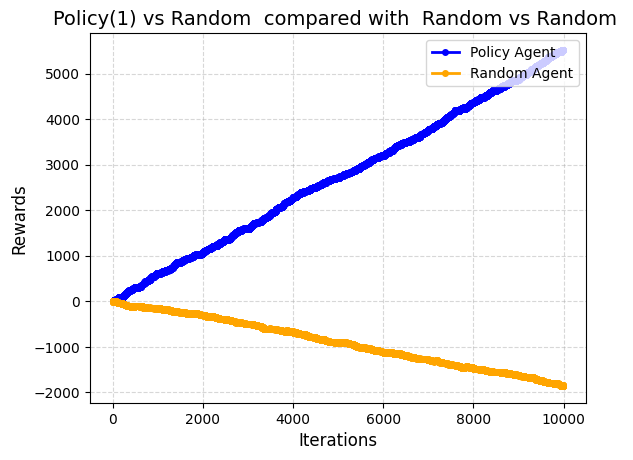

Execution time: 74.9757571220398 seconds
The average reward is: 0.9527


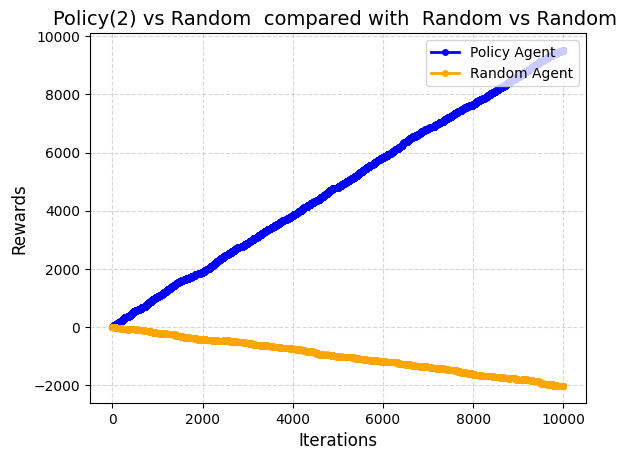

Execution time: 52.47336459159851 seconds


In [ ]:
# compete as player 1
runPlots(Random_Agent,1)
# compete as player 2
runPlots(Random_Agent,2)

Compete against a Threshold player and compare it with Random Vs Threshold

The average reward is: 0.0681


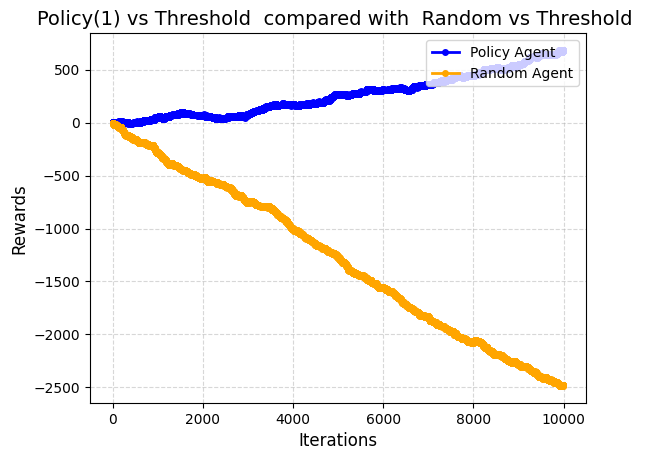

Execution time: 56.46919298171997 seconds
The average reward is: 0.15185


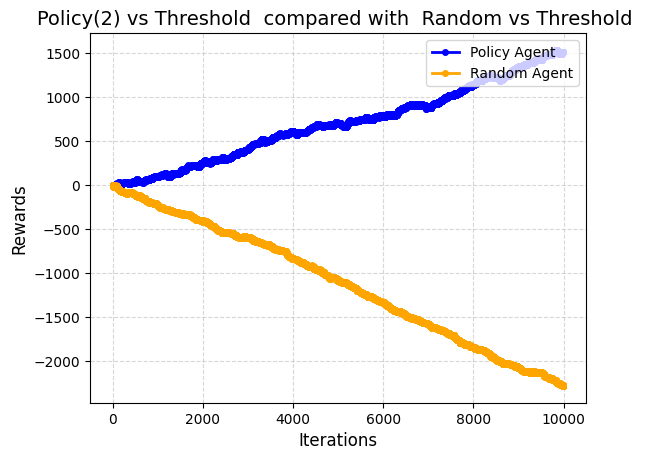

Execution time: 36.09480834007263 seconds


In [ ]:
# compete as player 1
runPlots(Threshold_Agent,1)
# compete as player 2
runPlots(Threshold_Agent,2)